<a href="https://colab.research.google.com/github/Thrinadh-25/safestreet/blob/final/vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
rdd_india_path = '/content/drive/MyDrive/dataset/india/train'


In [ ]:
!pip install bing-image-downloader


In [ ]:
import os
import shutil
from PIL import Image
from bing_image_downloader import downloader

# Setup base path
root_dir = '/content/road_binary_dataset'
road_dir = os.path.join(root_dir, 'road')
not_road_dir = os.path.join(root_dir, 'not_road')
os.makedirs(road_dir, exist_ok=True)
os.makedirs(not_road_dir, exist_ok=True)

# STEP 1: Copy RDD2024 India images from Drive to 'road'
rdd_india_path = '/content/drive/MyDrive/dataset/india/train'  # CHANGE THIS
for file in os.listdir(rdd_india_path):
    if file.endswith('.jpg'):
        shutil.copy(os.path.join(rdd_india_path, file), os.path.join(road_dir, file))

print(f"✅ Copied {len(os.listdir(road_dir))} road images.")

# STEP 2: Download non-road images
non_road_queries = ["cat", "indoor", "kitchen", "face", "sky", "animal", "furniture", "forest"]
for query in non_road_queries:
    downloader.download(query, limit=30, output_dir=root_dir, adult_filter_off=True, timeout=60)

# STEP 3: Move downloaded images into 'not_road', handling both subfolder and direct image case
for folder in os.listdir(root_dir):
    if folder not in ['road', 'not_road']:
        folder_path = os.path.join(root_dir, folder)
        if os.path.isdir(folder_path):
            # Check if it has subfolders (like "sky/sky/*.jpg")
            subitems = os.listdir(folder_path)
            if len(subitems) == 1 and os.path.isdir(os.path.join(folder_path, subitems[0])):
                subfolder_path = os.path.join(folder_path, subitems[0])
                for file in os.listdir(subfolder_path):
                    shutil.move(os.path.join(subfolder_path, file), os.path.join(not_road_dir, file))
            else:
                # If no subfolder, move directly
                for file in subitems:
                    file_path = os.path.join(folder_path, file)
                    if os.path.isfile(file_path):
                        shutil.move(file_path, os.path.join(not_road_dir, file))
            shutil.rmtree(folder_path)

print(f"✅ Moved all downloaded non-road images into {not_road_dir}")


# STEP 4: Resize all images
def resize_images(folder, size=(224, 224)):
    for file in os.listdir(folder):
        try:
            path = os.path.join(folder, file)
            img = Image.open(path).convert('RGB').resize(size)
            img.save(path)
        except Exception as e:
            print(f"❌ Error with {file}: {e}")

resize_images(road_dir)
resize_images(not_road_dir)

print("✅ All images resized and ready for training!")


✅ Copied 977 road images.
[%] Downloading Images to /content/road_binary_dataset/cat


[!!]Indexing page: 1

[%] Indexed 60 Images on Page 1.


[%] Downloading Image #1 from https://www.sabinovetcare.com/wp-content/uploads/sites/169/2021/11/cat-318794-scaled.jpg
[!] Issue getting: https://www.sabinovetcare.com/wp-content/uploads/sites/169/2021/11/cat-318794-scaled.jpg
[!] Error:: HTTP Error 403: Forbidden
[%] Downloading Image #1 from https://thediscerningcat.com/wp-content/uploads/2020/11/pexels-photo-2286016.jpeg
[%] File Downloaded !

[%] Downloading Image #2 from https://wallup.net/wp-content/uploads/2016/01/66130-cat-animals.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://healthysolutionsforpets.com/wp-content/uploads/2020/01/bigstock-Close-up-Portrait-Of-Cute-Thai-325729861-compressor-scaled.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://images2.alphacoders.com/121/1213770.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://media.np

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import os

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths
dataset_path = '/content/road_binary_dataset'
batch_size = 32
img_size = 224
num_epochs = 10

# Transformations
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Simple normalization
])

# Load dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
class_names = dataset.classes
print(f"Classes: {class_names}")

# Train-val split (80-20)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Small CNN Model
class SmallCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SmallCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),  # input 3 channels (RGB)
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * (img_size//8) * (img_size//8), 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instantiate model
model = SmallCNN(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {acc:.4f}")

# Save model
model_path = "/content/road_classifier.pth"
torch.save(model.state_dict(), model_path)
print(f"✅ Model saved to {model_path}")


Using device: cuda
Classes: ['not_road', 'road']
Epoch 1/10, Train Loss: 6.4684, Train Acc: 0.9107
Epoch 2/10, Train Loss: 2.5937, Train Acc: 0.9686
Epoch 3/10, Train Loss: 1.1578, Train Acc: 0.9916
Epoch 4/10, Train Loss: 0.6631, Train Acc: 0.9940
Epoch 5/10, Train Loss: 0.4775, Train Acc: 0.9952
Epoch 6/10, Train Loss: 0.2246, Train Acc: 0.9976
Epoch 7/10, Train Loss: 0.2379, Train Acc: 0.9988
Epoch 8/10, Train Loss: 0.0976, Train Acc: 1.0000
Epoch 9/10, Train Loss: 0.0988, Train Acc: 1.0000
Epoch 10/10, Train Loss: 0.1208, Train Acc: 1.0000
✅ Model saved to /content/road_classifier.pth


Saving India_000130_jpg.rf.e039fa0b95f48143b1d9b9c95d011d4c.jpg to India_000130_jpg.rf.e039fa0b95f48143b1d9b9c95d011d4c (1).jpg


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


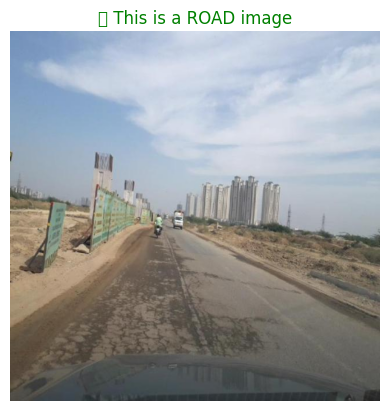

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Load model for inference
model = SmallCNN(num_classes=2).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Inference transform (same as training)
inference_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Upload and predict
from google.colab import files
uploaded = files.upload()

for file_name in uploaded.keys():
    # Load image
    image = Image.open(file_name).convert('RGB')
    input_tensor = inference_transform(image).unsqueeze(0).to(device)

    # Prediction
    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).item()

    # Display result
    plt.imshow(image)
    plt.axis('off')
    label = class_names[pred]
    if label == "road":
        plt.title("✅ This is a ROAD image", color="green")
    else:
        plt.title("⚠️ Not a ROAD image", color="red")
    plt.show()


In [ ]:
!pip install onnx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 118.1 MB/s eta 0:00:00


In [ ]:
dummy_input = torch.randn(1, 3, img_size, img_size).to(device)
onnx_path = "/content/road_classifier.onnx"

torch.onnx.export(
    model, dummy_input, onnx_path,
    input_names=["input"], output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=11
)

print(f"✅ Model converted to ONNX format at {onnx_path}")


✅ Model converted to ONNX format at /content/road_classifier.onnx


In [ ]:
!pip install onnx onnxruntime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.7 MB/s eta 0:00:00


In [ ]:
import onnx

# Load the model
onnx_model = onnx.load("/content/road_classifier.onnx")

# Check that the model is well formed
try:
    onnx.checker.check_model(onnx_model)
    print("✅ ONNX model is valid!")
except onnx.checker.ValidationError as e:
    print(f"❌ ONNX model validation failed: {e}")


✅ ONNX model is valid!


In [ ]:
import onnxruntime as ort
import numpy as np

# Create inference session
session = ort.InferenceSession("/content/road_classifier.onnx")

# Dummy input (same shape as training)
dummy_input = np.random.randn(1, 3, 224, 224).astype(np.float32)

# Run inference
outputs = session.run(None, {"input": dummy_input})
print("✅ ONNX model inference successful. Output:", outputs[0])


✅ ONNX model inference successful. Output: [[11.091391 -7.971362]]
